In [25]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiLineString, LineString,MultiPolygon, MultiPoint
os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')
pd.options.display.max_columns = None



In [ ]:
# Load Data
flowlines_gdf = gpd.read_file('flowlines.geojson')
crudeoil_offlocation_gdf = gpd.read_file('crudeoil_offlocation.geojson')

In [3]:
# Check size
print(flowlines_gdf.shape)
print(crudeoil_offlocation_gdf.shape)

(21942, 19)
(259979, 8)


In [4]:
flowlines_gdf.head(2)

,LOCATION_ID,FLOWLINEID,STARTLOCATIONID,FLOWLINEACTION,ENTIRELINEREMOVED,ACTIONDESCRIPTION,RECEIVE_DATE,OPERATOR_NUM,COMPANY_NAME,LOCATIONTYPE,ENDLAT,ENDLONG,STARTLAT,STARTLONG,PIPEMATERIAL,BEDDINGMATERIAL,TYPEOFFLUIDTRANS,MAXOPPRESSURE,geometry
0,331872.0,485633.0,NaN,Registration,None,None,2023-10-30T08:10:52.119999,10673,GADECO LLC ...,Well Site,NaN,NaN,NaN,NaN,HDPE,Native Materials,Produced Water,NaN,None
1,470443.0,470446.0,NaN,None,None,The flowline serving the Emerson 3-29J (05-123...,2023-10-24T08:33:49.223000,10633,CRESTONE PEAK RESOURCES OPERATING LLC ...,Production Facilities,40.109444,-104.909686,40.105743,-104.90986,Carbon Steel,Native Materials,Multiphase,325.0,"LINESTRING (507682.442 4439497.658, 507696.855..."


In [5]:
crudeoil_offlocation_gdf.head(2)

,Operator,Fluid,Material,Diam_in,Status,Length_ft,SHAPE_Length,geometry
0,EVERGREEN NATURAL RESOURCES LLC,Gas,polly,4.0,Active,2277.71,693.972162,"MULTILINESTRING ((524642.670 4117088.796, 5246..."
1,NOBLE ENERGY INC,Multiphase,Carbon Steel,3.0,Abandoned,651.58,198.525215,"MULTILINESTRING ((527997.281 4463899.920, 5281..."


In [6]:
# Check if CRS is the same for both files
if flowlines_gdf.crs != crudeoil_offlocation_gdf.crs:
    flowlines_gdf = flowlines_gdf.to_crs(crudeoil_offlocation_gdf.crs)

In [7]:
# Spatial join to find intersecting geometries
# Add attributes from flowlines to matching entries in crude_oil_gdf
matches_gdf = gpd.sjoin(crudeoil_offlocation_gdf, flowlines_gdf, how="inner", op='intersects')
matches_gdf.shape

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


(108291, 27)

In [8]:
flowlines_gdf.head(2)

,LOCATION_ID,FLOWLINEID,STARTLOCATIONID,FLOWLINEACTION,ENTIRELINEREMOVED,ACTIONDESCRIPTION,RECEIVE_DATE,OPERATOR_NUM,COMPANY_NAME,LOCATIONTYPE,ENDLAT,ENDLONG,STARTLAT,STARTLONG,PIPEMATERIAL,BEDDINGMATERIAL,TYPEOFFLUIDTRANS,MAXOPPRESSURE,geometry
0,331872.0,485633.0,NaN,Registration,None,None,2023-10-30T08:10:52.119999,10673,GADECO LLC ...,Well Site,NaN,NaN,NaN,NaN,HDPE,Native Materials,Produced Water,NaN,None
1,470443.0,470446.0,NaN,None,None,The flowline serving the Emerson 3-29J (05-123...,2023-10-24T08:33:49.223000,10633,CRESTONE PEAK RESOURCES OPERATING LLC ...,Production Facilities,40.109444,-104.909686,40.105743,-104.90986,Carbon Steel,Native Materials,Multiphase,325.0,"LINESTRING (507682.442 4439497.658, 507696.855..."


In [9]:
from shapely.geometry import Point
## Make an endpoint spatial join function
flindex = pd.DataFrame()
for index, row in flowlines_gdf[flowlines_gdf.geometry.notnull()].drop_duplicates(subset='FLOWLINEID',keep='first').iterrows():
    flp0, flp1 = list(row['geometry'].coords)
    t = gpd.GeoDataFrame({'geometry':[Point(flp0),Point(flp1)],
                          #'oindex':[index,index]},
                          'flowlineID':[row['FLOWLINEID']]*2},
                          geometry='geometry',crs=flowlines_gdf.crs)
    flindex = pd.concat([flindex,t],ignore_index=True)



In [23]:
def endpoint_buffer(row,crd=crudeoil_offlocation_gdf,buffer=25,returnPnts=False):
    '''
    Takes a line or multiline and returns a merged geometry of its endpoints with a buffer

    row: pandas iterrows
    
    '''
    if isinstance(row['geometry'],MultiLineString):
        coords = []
        for geom in row['geometry'].geoms:
            subgeom_coords = list(geom.coords)
            coords.append(subgeom_coords[0])
            coords.append(subgeom_coords[-1])
    else:        
        coords = list(row['geometry'].coords)

    pnts = [Point(xy) for xy in coords]
    if returnPnts:
        return MultiPoint(pnts)
    temp = gpd.GeoDataFrame({'geometry':pnts},crs=crd.crs).unary_union.buffer(buffer)
    return temp

In [16]:
#flgemo = flindex.unary_union.buffer(25*1000)
#flgemo

crudeoil_offlocation_gdf[crudeoil_offlocation_gdf['geometry'].apply(lambda x: isinstance(x, MultiPolygon))]

,Operator,Fluid,Material,Diam_in,Status,Length_ft,SHAPE_Length,geometry


In [21]:
crd_ends = pd.DataFrame()
for index, row in crudeoil_offlocation_gdf[crudeoil_offlocation_gdf.geometry.notnull()].iterrows():
    #if index < 199625: continue
    tgeom = endpoint_buffer(row)
    t = gpd.GeoDataFrame({'crdindex':[index],'geometry':[tgeom]})
    
    crd_ends = pd.concat([crd_ends,t],ignore_index=True)

    #Print status for building endpoint GDF
    if index % 100 == 0:
        print(round(index/crudeoil_offlocation_gdf.shape[0]*100,2),'%   ',end='\r') 

In [1]:
crudeoil_offlocation_gdf.head(2)

NameError: name 'crudeoil_offlocation_gdf' is not defined

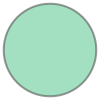

In [30]:
index / crudeoil_offlocation_gdf.shape[0],index
srch_geom = endpoint_buffer(row,buffer=5)
srch_geom

Run the flindex > crd and save matched flowlineIDs to crd and save.  This can then be used with a number of matches column in qgis to look ath the locations that you are getting matches. ie crd['flnidN'] = crd.flowlineIDs.apply(lambda x: len(x))

For the crd > flines remake the crd_endpoints as just endpoints as indexes *not* a multipoint and try again.

In [29]:
flindex['crdindexs'] = [[]]*flindex.shape[0]

for index, row in flindex.iterrows():
    srch_geom = endpoint_buffer(row,buffer=5)
    mtch = crd_ends[crd_ends.intersects(srch_geom)].crdindex.tolist()
    if len(mtch) == 0:
        #print(index)
        #no_count += 1
        #if no_count >= 10:
        #    break
        continue
    #print(mtch)
    mtch = {x for x in mtch if mtch.count(x) == 2}
    #print(mtch)
    if len(mtch) == 1:
        mi += 1
    elif len(mtch) > 1:
        oi += 1
    #break
    flindex.at[index,'crdindexs'] = list(mtch)

        #Print status for building endpoint GDF
    if index % 100 == 0:
        print(round(index/flindex.shape[0]*100,2),'%   ',end='\r')
    

mi / flindex.shape[0], oi / flindex.shape[0]

KeyboardInterrupt: 

In [28]:
flindex[flindex.crdindexs.apply(lambda x: len(x) == 0)].shape[0] / flindex.shape[0]
crd_ends.to_file('crd_ends.shp')

In [54]:
crd = crudeoil_offlocation_gdf[crudeoil_offlocation_gdf.intersects(flgemo)]
crd['flowlineIDs'] = [[]]*crd.shape[0]
#if False:
#    for index, row in crd.iterrows():
#        crp = list(row['geometry'].coords)
#        crp0,crp1 = crp[0],crp[-1]
#        mtch0 = set(flindex[flindex.intersects(crp0)]['flowlineID'].tolist())
#        mtch1 = set(flindex[flindex.intersects(crp1)]['flowlineID'].tolist())
#        mtchoindex = mtch0 & mtch1 #leaving this here for now to move towards endpoints being on any point in the line

mi = 0
oi = 0
no_count = 0
for index, row in crd.iterrows():
    srch_geom = endpoint_buffer(row)
    mtch = flindex[flindex.intersects(srch_geom)].flowlineID.tolist()
    if len(mtch) == 0:
        print(index)
        no_count += 1
        if no_count >= 10:
            break
        continue
    #print(mtch)
    mtch = {x for x in mtch if mtch.count(x) == 2}
    #print(mtch)
    if len(mtch) == 1:
        mi += 1
    elif len(mtch) > 1:
        oi += 1
    #break
    crd.at[index,'flowlineIDs'] = list(mtch)
    

mi / crd.shape[0], oi / crd.shape[0]

0
1
3
4
6
7
8
10
11
12


(3.84646452213448e-06, 0.0)

In [32]:
#crd[crd.index == index].buffer(25).to_file('crd_buffer25c.shp')
flindex[flindex.intersects(srch_geom)].to_file('match_o_flindexD.shp')
gpd.GeoDataFrame({'geometry':[srch_geom]},crs=crd.crs).to_file('srch_geomD.shp')
#flindex.to_file('flindex.shp')

In [19]:
type(row['geometry'])

shapely.geometry.multilinestring.MultiLineString

In [ ]:
crd.crs

<Projected CRS: EPSG:26913>
Name: NAD83 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 108°W and 102°W - onshore and offshore. Canada - Northwest Territories; Nunavut; Saskatchewan. United States (USA) - Colorado; Montana; Nebraska; New Mexico; North Dakota; Oklahoma; South Dakota; Texas; Wyoming.
- bounds: (-108.0, 28.98, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
print(matches_gdf[['COMPANY_NAME', 'Operator']].sample(10))

                                              COMPANY_NAME                               Operator
134299  TIMBER CREEK OPERATING LLC                                     TIMBER CREEK OPERATING LLC
2098    NOBLE ENERGY INC                                                         NOBLE ENERGY INC
104664  TIMBER CREEK OPERATING LLC                                     TIMBER CREEK OPERATING LLC
7290    SEELEY OIL COMPANY LLC                                             SEELEY OIL COMPANY LLC
60649   SMITH ENERGY LLC                                                         SMITH ENERGY LLC
41945   MARALEX RESOURCES INC                                               MARALEX RESOURCES INC
58248   NOBLE ENERGY INC                                                         NOBLE ENERGY INC
205     CRESTONE PEAK RESOURCES OPERATING LLC               CRESTONE PEAK RESOURCES OPERATING LLC
117060  NOBLE ENERGY INC                                                         NOBLE ENERGY INC
23212   KP KAUFFMAN 

In [ ]:
matches_gdf[['COMPANY_NAME','Operator']].head(10)

,COMPANY_NAME,Operator
2,PDC ENERGY INC ...,PDC ENERGY INC
2,PDC ENERGY INC ...,PDC ENERGY INC
2,PDC ENERGY INC ...,PDC ENERGY INC
2,PDC ENERGY INC ...,PDC ENERGY INC
5,NOBLE ENERGY INC ...,NOBLE ENERGY INC
5,NOBLE ENERGY INC ...,NOBLE ENERGY INC
14,BONANZA CREEK ENERGY OPERATING COMPANY LLC ...,BONANZA CREEK ENERGY OPERATING COMPANY LLC
14,BONANZA CREEK ENERGY OPERATING COMPANY LLC ...,BONANZA CREEK ENERGY OPERATING COMPANY LLC
14,BONANZA CREEK ENERGY OPERATING COMPANY LLC ...,BONANZA CREEK ENERGY OPERATING COMPANY LLC
14,BONANZA CREEK ENERGY OPERATING COMPANY LLC ...,BONANZA CREEK ENERGY OPERATING COMPANY LLC


In [ ]:
pd.set_option('display.max_colwidth',None)
matches_gdf[['COMPANY_NAME','Operator']].head(10)

,COMPANY_NAME,Operator
2,PDC ENERGY INC,PDC ENERGY INC
2,PDC ENERGY INC,PDC ENERGY INC
2,PDC ENERGY INC,PDC ENERGY INC
2,PDC ENERGY INC,PDC ENERGY INC
5,NOBLE ENERGY INC,NOBLE ENERGY INC
5,NOBLE ENERGY INC,NOBLE ENERGY INC
14,BONANZA CREEK ENERGY OPERATING COMPANY LLC,BONANZA CREEK ENERGY OPERATING COMPANY LLC
14,BONANZA CREEK ENERGY OPERATING COMPANY LLC,BONANZA CREEK ENERGY OPERATING COMPANY LLC
14,BONANZA CREEK ENERGY OPERATING COMPANY LLC,BONANZA CREEK ENERGY OPERATING COMPANY LLC
14,BONANZA CREEK ENERGY OPERATING COMPANY LLC,BONANZA CREEK ENERGY OPERATING COMPANY LLC


In [ ]:
validated_matches = matches_gdf[matches_gdf['COMPANY_NAME'] == matches_gdf['Operator']]
validated_matches.shape

(0, 27)

KeyError: 0

In [ ]:
# remove the trailing spaces and ellipses from COMPANY_NAME

# Strip leading and trailing whitespace
matches_gdf['COMPANY_NAME'] = matches_gdf['COMPANY_NAME'].str.strip()

# Replace ellipses and any excess internal spaces with a single space
matches_gdf['COMPANY_NAME'] = matches_gdf['COMPANY_NAME'].str.replace(r"\.\.\.+", "", regex=True)  # Removes ellipses
matches_gdf['COMPANY_NAME'] = matches_gdf['COMPANY_NAME'].str.replace(r"\s+", " ", regex=True)  # Replaces multiple spaces with a single space

In [ ]:
# Validate spatial merge by COMPANY_NAME/Operator
validated_matches = matches_gdf[matches_gdf['COMPANY_NAME'] == matches_gdf['Operator']]
validated_matches.shape

(98657, 27)

In [ ]:
print(validated_matches[['COMPANY_NAME', 'Operator']].sample(10))

                                     COMPANY_NAME  \
28671                      TEP ROCKY MOUNTAIN LLC   
47553                              PDC ENERGY INC   
55242                              PDC ENERGY INC   
60362  BONANZA CREEK ENERGY OPERATING COMPANY LLC   
92876                 OWN RESOURCES OPERATING LLC   
44416                     KP KAUFFMAN COMPANY INC   
96035                     KP KAUFFMAN COMPANY INC   
94201                            NOBLE ENERGY INC   
21146       CRESTONE PEAK RESOURCES OPERATING LLC   
83807                            NOBLE ENERGY INC   

                                         Operator  
28671                      TEP ROCKY MOUNTAIN LLC  
47553                              PDC ENERGY INC  
55242                              PDC ENERGY INC  
60362  BONANZA CREEK ENERGY OPERATING COMPANY LLC  
92876                 OWN RESOURCES OPERATING LLC  
44416                     KP KAUFFMAN COMPANY INC  
96035                     KP KAUFFMAN COMPANY INC  


In [ ]:
validated_matches.head(10)

,Operator,Fluid,Material,Diam_in,Status,Length_ft,SHAPE_Length,geometry,index_right,LOCATION_ID,FLOWLINEID,STARTLOCATIONID,FLOWLINEACTION,ENTIRELINEREMOVED,ACTIONDESCRIPTION,RECEIVE_DATE,OPERATOR_NUM,COMPANY_NAME,LOCATIONTYPE,ENDLAT,ENDLONG,STARTLAT,STARTLONG,PIPEMATERIAL,BEDDINGMATERIAL,TYPEOFFLUIDTRANS,MAXOPPRESSURE
2,PDC ENERGY INC,None,None,NaN,Partial Removed see comment,1902.59,579.687012,"MULTILINESTRING ((537519.211 4475984.687, 5375...",11709,472043.0,472044.0,332067.0,Registration,None,None,2019-10-03T10:17:51.337002,69175,PDC ENERGY INC,Production Facilities,40.433678,-104.564457,40.429625,-104.562114,Carbon Steel,None,Crude Oil,NaN
2,PDC ENERGY INC,None,None,NaN,Partial Removed see comment,1902.59,579.687012,"MULTILINESTRING ((537519.211 4475984.687, 5375...",7856,472043.0,472044.0,332067.0,None,None,None,2020-06-02T08:02:30.473000,69175,PDC ENERGY INC,Well Site,40.433678,-104.564457,40.429625,-104.562114,Carbon Steel,None,Crude Oil,NaN
2,PDC ENERGY INC,None,None,NaN,Partial Removed see comment,1902.59,579.687012,"MULTILINESTRING ((537519.211 4475984.687, 5375...",11710,472043.0,472045.0,305898.0,Registration,None,None,2019-10-03T10:17:51.337002,69175,PDC ENERGY INC,Production Facilities,40.433678,-104.564457,40.432222,-104.559722,Carbon Steel,None,Crude Oil,NaN
2,PDC ENERGY INC,None,None,NaN,Partial Removed see comment,1902.59,579.687012,"MULTILINESTRING ((537519.211 4475984.687, 5375...",7857,472043.0,472045.0,305898.0,None,None,None,2020-06-02T08:02:30.473000,69175,PDC ENERGY INC,Well Site,40.433678,-104.564457,40.432222,-104.559722,Carbon Steel,None,Crude Oil,NaN
5,NOBLE ENERGY INC,Multiphase,Carbon Steel,3.0,Abandoned,1118.30,340.724313,"MULTILINESTRING ((530315.537 4449292.793, 5304...",21778,330724.0,456334.0,336483.0,Registration,None,None,2018-06-25T11:33:36.369999,100322,NOBLE ENERGY INC,Production Facilities,40.194494,-104.647039,40.194907,-104.642040,None,None,None,NaN
5,NOBLE ENERGY INC,Multiphase,Carbon Steel,3.0,Abandoned,1118.30,340.724313,"MULTILINESTRING ((530315.537 4449292.793, 5304...",16585,330724.0,456334.0,336483.0,Abandonment,1,"Purged fluids, abandoned in place, cut risers ...",2019-06-10T12:58:49.646999,100322,NOBLE ENERGY INC,Production Facilities,40.194494,-104.647039,40.194907,-104.642040,None,None,None,NaN
14,BONANZA CREEK ENERGY OPERATING COMPANY LLC,Crude Oil,Carbon Steel,6.0,Active,6160.57,1877.062024,"MULTILINESTRING ((556593.657 4470563.616, 5565...",14499,423766.0,467329.0,423761.0,Registration,None,None,2019-09-05T09:54:31.670000,8960,BONANZA CREEK ENERGY OPERATING COMPANY LLC,Well Site,40.379677,-104.355140,40.379670,-104.350010,Carbon Steel,Native Materials,Crude Oil Emulsion,NaN
14,BONANZA CREEK ENERGY OPERATING COMPANY LLC,Crude Oil,Carbon Steel,6.0,Active,6160.57,1877.062024,"MULTILINESTRING ((556593.657 4470563.616, 5565...",14500,423766.0,467328.0,423761.0,Registration,None,None,2019-09-05T09:54:31.670000,8960,BONANZA CREEK ENERGY OPERATING COMPANY LLC,Well Site,40.379677,-104.355142,40.379670,-104.349950,Carbon Steel,Native Materials,Crude Oil Emulsion,NaN
14,BONANZA CREEK ENERGY OPERATING COMPANY LLC,Crude Oil,Carbon Steel,6.0,Active,6160.57,1877.062024,"MULTILINESTRING ((556593.657 4470563.616, 5565...",14498,423761.0,467330.0,423766.0,Registration,None,None,2019-09-05T10:04:52.240002,8960,BONANZA CREEK ENERGY OPERATING COMPANY LLC,Well Site,40.379670,-104.350010,40.379699,-104.355181,HDPE,Native Materials,Natural Gas,NaN
14,BONANZA CREEK ENERGY OPERATING COMPANY LLC,Crude Oil,Carbon Steel,6.0,Active,6160.57,1877.062024,"MULTILINESTRING ((556593.657 4470563.616, 5565...",14497,423761.0,467331.0,423766.0,Registration,None,None,2019-09-05T10:04:52.240002,8960,BONANZA CREEK ENERGY OPERATING COMPANY LLC,Well Site,40.379670,-104.349950,40.379699,-104.355181,HDPE,Native Materials,Natural Gas,NaN


In [ ]:
# Merge the matches back to the original 'crudeoil_offlocation_gdf' to add 'flowlines_gdf' attributes where intersections occurred

# Dropp the 'index_right' column which is added by sjoin and duplicate geometry column
validated_matches.drop(columns=['index_right','geometry','Operator','Fluid','Material','Diam_in','Status','Length_ft','SHAPE_Length'], inplace=True)

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_2520/847419937.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validated_matches.drop(columns=['index_right','geometry','Operator','Fluid','Material','Diam_in','Status','Length_ft','SHAPE_Length'], inplace=True)


In [ ]:
# Merge based on index, ensuring all original entries in 'crudeoil_offlocation_gdf' are retained and adding 'flowlines_gdf' attributes where matches were found
all_flowlines = crudeoil_offlocation_gdf.merge(validated_matches, left_index=True, right_index=True, how="left")

In [ ]:
print(crudeoil_offlocation_gdf.shape)
print(all_flowlines.shape)

(259979, 8)
(335174, 26)


In [ ]:
all_flowlines.head(2)

,Operator,Fluid,Material,Diam_in,Status,Length_ft,SHAPE_Length,geometry,LOCATION_ID,FLOWLINEID,STARTLOCATIONID,FLOWLINEACTION,ENTIRELINEREMOVED,ACTIONDESCRIPTION,RECEIVE_DATE,OPERATOR_NUM,COMPANY_NAME,LOCATIONTYPE,ENDLAT,ENDLONG,STARTLAT,STARTLONG,PIPEMATERIAL,BEDDINGMATERIAL,TYPEOFFLUIDTRANS,MAXOPPRESSURE
0,EVERGREEN NATURAL RESOURCES LLC,Gas,polly,4.0,Active,2277.71,693.972162,"MULTILINESTRING ((524642.670 4117088.796, 5246...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NOBLE ENERGY INC,Multiphase,Carbon Steel,3.0,Abandoned,651.58,198.525215,"MULTILINESTRING ((527997.281 4463899.920, 5281...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
all_flowlines.to_file('all_flowlines.geojson', driver='GeoJSON')